In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from scipy.stats import kurtosis
import random

Model is trained and tested on the fourth_batch with train test split.

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [12]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.01)
        Q3 = df[col].quantile(0.99)
        IQR = Q3 - Q1

        # Define the outlier range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove rows with outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

def engineer_features(df_X, df_y = None, remove_outliers_flag=False):
    # Basic user features
    df_user_features = df_X.groupby("user").agg(
        mean_rating=("rating", "mean"),
        median_rating=("rating", "median"),
        std_rating=("rating", "std"),
        count_dislike=("rating", lambda x: (x == -10).sum()),
        count_neutral=("rating", lambda x: (x == 0).sum()),
        count_like=("rating", lambda x: (x == 10).sum()),
        count_watched=("rating", lambda x: (x == 1).sum()),
        total_interactions=("rating", "count"),
    )

    # Ratio features
    df_user_features["like_ratio"] = (
        df_user_features["count_like"] / df_user_features["total_interactions"]
    )
    df_user_features["dislike_ratio"] = (
        df_user_features["count_dislike"] / df_user_features["total_interactions"]
    )
    df_user_features["neutral_ratio"] = (
        df_user_features["count_neutral"] / df_user_features["total_interactions"]
    )
    df_user_features["watched_ratio"] = (
        df_user_features["count_watched"] / df_user_features["total_interactions"]
    )

    # Weighted scores
    df_user_features["weighted_score"] = (
        df_user_features["count_like"] * 1.5 - df_user_features["count_dislike"] * 1.5
    )

    # Distribution features
    df_user_features["rating_kurtosis"] = df_X.groupby("user")["rating"].apply(
        lambda x: kurtosis(x)
    )

    # Item popularity metrics
    item_popularity = df_X.groupby("item")["rating"].agg(["mean", "count"])
    item_popularity["popularity_score"] = item_popularity["mean"] * np.log1p(
        item_popularity["count"]
    )

    # Merge item popularity with user interactions
    df_X_with_popularity = pd.merge(
        df_X, item_popularity["popularity_score"], left_on="item", right_index=True
    )

    # New features
    df_user_features["avg_deviation_from_popularity"] = df_X_with_popularity.groupby(
        "user"
    ).apply(lambda x: np.abs(x["rating"] - x["popularity_score"]).mean())

    # Drop columns with high correlation
    # Count watch has high correlation with total interactions
    df_user_features.drop(columns=["total_interactions"], inplace=True)

    # Drop columns with low mutual information
    df_user_features.drop(columns=["median_rating"], inplace=True)
    df_user_features.drop(columns=["mean_rating"], inplace=True)
    
    if df_y is not None:
        df_merged = pd.merge(df_user_features.reset_index(), df_y, on="user")
        # Return the merged dataframe with selected features, label, and top features
        return df_merged
    else:
        return df_user_features

In [4]:
# Load and prepare data
raw_data = np.load("../data/fourth_batch_multi_labels.npz")
interaction_data = pd.DataFrame(raw_data["X"], columns=["user", "item", "rating"])
user_labels = pd.DataFrame(raw_data["yy"], columns=["user", "label"])

# Split data into train and test sets
train_labels, test_labels = train_test_split(
    user_labels, test_size=0.2, random_state=RANDOM_SEED
)

# Split interaction data based on user splits
train_interactions = interaction_data[
    interaction_data["user"].isin(train_labels["user"])
]

# Generate features for train and test sets
train_data = engineer_features(train_interactions, train_labels, remove_outliers_flag=True)

# Ensure that test interactions only contain users present in test labels
test_interactions = interaction_data[interaction_data["user"].isin(test_labels["user"])]

# Regenerate features after filtering
test_data = engineer_features(test_interactions, test_labels)

# Prepare final feature matrices and labels
X_train = train_data.drop(columns=["user", "label"])
y_train = train_data["label"]

X_test = test_data.drop(columns=["user", "label"])
y_test = test_data["label"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTETomek(random_state=RANDOM_SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

C:\Users\teoju\AppData\Local\Temp\ipykernel_34580\2216100997.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: np.abs(x["rating"] - x["popularity_score"]).mean())
C:\Users\teoju\AppData\Local\Temp\ipykernel_34580\2216100997.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: np.abs(x["rating"] - x["popularity_score"]).mean())


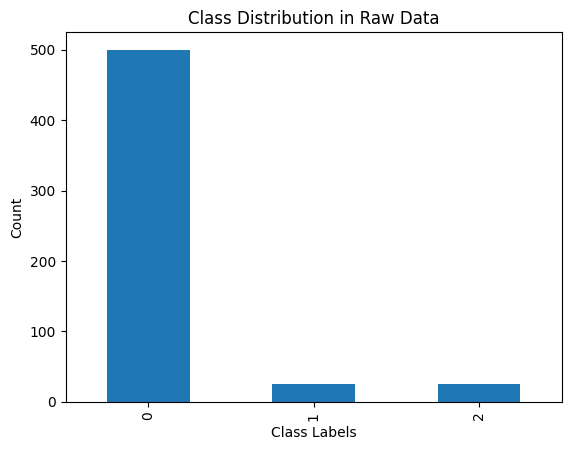

In [5]:
label_distribution = user_labels['label'].value_counts()

# Plot the distribution of classes
label_distribution.plot(kind='bar')
plt.title("Class Distribution in Raw Data")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.show()

In [6]:
# Define KMeans for clustering
kmeans = KMeans(n_clusters=5, random_state=RANDOM_SEED)

# Define Logistic Regression model
logreg_model = LogisticRegression(random_state=RANDOM_SEED)

# Define Random Forest model
rf_model = RandomForestClassifier(random_state=RANDOM_SEED)

# Define KNN model
knn_model = KNeighborsClassifier()

# Define the Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg_model),
        ('rf', rf_model),
        ('knn', knn_model),
    ],
    voting='soft'  # Use 'soft' voting to combine predicted probabilities
)

# Create a pipeline that first applies KMeans, then applies the Voting Classifier
pipeline = Pipeline([
    ('kmeans', kmeans),
    ('voting', voting_clf)
])

# Define parameter grid for Voting Classifier
param_grid_voting = {
    # KMeans parameters
    'kmeans__n_clusters': [3, 5, 7],

    # Logistic Regression parameters
    'voting__logreg__C': [0.1, 1, 10],
    'voting__logreg__penalty': ['l1', 'l2', 'elasticnet'],
    'voting__logreg__solver': ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'],
    'voting__logreg__max_iter': [1000],

    # Random Forest parameters
    'voting__rf__n_estimators': [50, 100, 200],
    'voting__rf__max_depth': [None],
    'voting__rf__min_samples_split': [2, 5, 10],
    'voting__rf__min_samples_leaf': [1],

    # KNN parameters
    'voting__knn__n_neighbors': [3, 5, 7],
    'voting__knn__weights': ['uniform', 'distance'],
    'voting__knn__p': [2],  # 1: Manhattan distance, 2: Euclidean distance
}

# Initialize RandomizedSearchCV for the pipeline
random_search_voting = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid_voting,
    n_iter=300,
    scoring='roc_auc_ovr',
    cv=3,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

# Fit RandomizedSearchCV to the training data
random_search_voting.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by RandomizedSearchCV
print(f"Best Parameters (Voting Classifier): {random_search_voting.best_params_}")

# Use the best Voting Classifier model from RandomizedSearchCV
best_voting_model = random_search_voting.best_estimator_
model = best_voting_model

C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-milton-project\cs421-env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
501 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-milton-project\cs421-env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-milton-project\cs421-env\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
     

Best Parameters (Voting Classifier): {'voting__rf__n_estimators': 200, 'voting__rf__min_samples_split': 2, 'voting__rf__min_samples_leaf': 1, 'voting__rf__max_depth': None, 'voting__logreg__solver': 'liblinear', 'voting__logreg__penalty': 'l1', 'voting__logreg__max_iter': 1000, 'voting__logreg__C': 1, 'voting__knn__weights': 'distance', 'voting__knn__p': 2, 'voting__knn__n_neighbors': 3, 'kmeans__n_clusters': 7}


In [7]:
def plot_multiclass_roc_curve(y_true, y_pred_probabilities, class_labels=[0, 1, 2]):
    # Convert labels to binary format
    binarized_labels = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = binarized_labels.shape[1]
    
    # Initialize dictionaries to store metrics
    false_positive_rates = {}
    true_positive_rates = {}
    auc_scores = {}
    
    # Create color map for plotting
    colors = ['blue', 'green', 'red']
    
    # Create plot
    plt.figure()
    
    # Calculate ROC curve and AUC for each class
    for class_idx in range(n_classes):
        # Calculate ROC curve metrics
        false_positive_rates[class_idx], true_positive_rates[class_idx], _ = roc_curve(
            binarized_labels[:, class_idx],
            y_pred_probabilities[:, class_idx]
        )
        # Calculate AUC score
        auc_scores[class_idx] = auc(
            false_positive_rates[class_idx],
            true_positive_rates[class_idx]
        )
        
        # Plot ROC curve for current class
        class_label = (f"{class_labels[class_idx]}" if class_labels 
                      else f"Class {class_idx}")
        plt.plot(
            false_positive_rates[class_idx],
            true_positive_rates[class_idx],
            color=colors[class_idx],
            lw=2,
            label=f"{class_label} (AUC = {auc_scores[class_idx]:.3f})"
        )
    
    # Calculate and plot average AUC
    average_auc = sum(auc_scores.values()) / n_classes
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.text(0.6, 0.3, f'Average AUC Score: {average_auc:.4f}')
    plt.legend(loc='lower right')
    
    # Show plot
    plt.grid(True, alpha=0.3)
    plt.show()

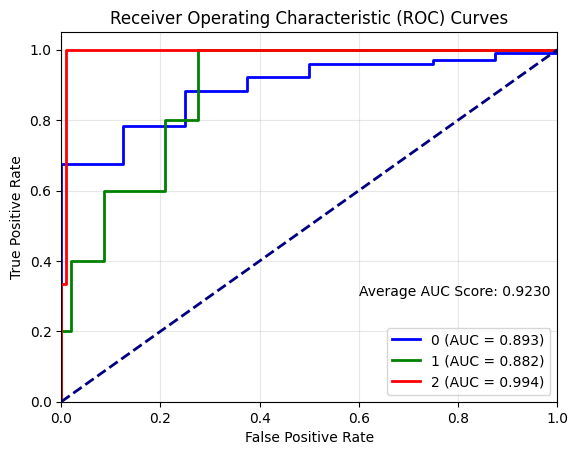

In [8]:
# Run prediction and plot ROC curve
plot_multiclass_roc_curve(y_test, model.predict_proba(X_test_scaled))

In [9]:
y_test.to_frame()

,label
0,0
1,0
2,0
3,1
4,0
...,...
105,0
106,0
107,0
108,0


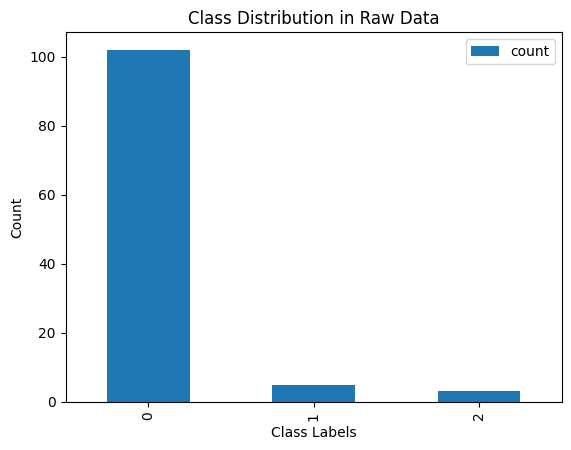

In [10]:
label_distribution = y_test.to_frame()['label'].value_counts()
label_distribution.to_frame().plot(kind='bar')
plt.title("Class Distribution in Raw Data")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.show()

In [22]:
data_fifth = np.load("../data/fifth_batch_multi.npz")
X_fifth = data_fifth['X']

df_X_fifth = pd.DataFrame(X_fifth, columns=["user", "item", "rating"])
df_merged_fifth = engineer_features(df_X_fifth, df_y=None,remove_outliers_flag=False)
display(df_merged_fifth.head(5))
X_fifth_scaled = scaler.transform(df_merged_fifth)
y_pred_proba_fifth = model.predict_proba(X_fifth_scaled)

df_predictions_fifth = pd.DataFrame({
    'user': df_merged_fifth.index,
    'z0': y_pred_proba_fifth[:, 0],
    'z1': y_pred_proba_fifth[:, 1],
    'z2': y_pred_proba_fifth[:, 2],
    'predicted_class': np.argmax(y_pred_proba_fifth, axis=1)
}).set_index('user')

C:\Users\teoju\AppData\Local\Temp\ipykernel_34580\1411213303.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: np.abs(x["rating"] - x["popularity_score"]).mean())


,std_rating,count_dislike,count_neutral,count_like,count_watched,like_ratio,dislike_ratio,neutral_ratio,watched_ratio,weighted_score,rating_kurtosis,avg_deviation_from_popularity
user,,,,,,,,,,,,
3790,5.480485,1,3,17,7,0.607143,0.035714,0.107143,0.250000,24.0,0.299984,11.201149
3791,8.989782,6,1,7,3,0.411765,0.352941,0.058824,0.176471,1.5,-1.663088,23.123969
3792,7.011842,19,21,45,32,0.384615,0.162393,0.179487,0.273504,39.0,-0.816920,12.435839
3793,4.976308,0,3,5,3,0.454545,0.000000,0.272727,0.272727,7.5,-1.948977,16.731619
3794,4.826087,12,91,47,73,0.210762,0.053812,0.408072,0.327354,52.5,0.705454,15.927917


In [23]:
df_predictions_fifth

,z0,z1,z2,predicted_class
user,,,,
3790,0.451752,0.547852,0.000397,1
3791,0.664471,0.000111,0.335419,0
3792,0.195515,0.763698,0.040787,1
3793,0.908220,0.089240,0.002540,0
3794,0.972414,0.022584,0.005002,0
...,...,...,...,...
5435,0.855509,0.143199,0.001292,0
5436,0.723521,0.275524,0.000954,0
5437,0.963548,0.033239,0.003212,0


In [27]:
df_final = df_predictions_fifth.drop(['predicted_class'], axis = 'columns')
import time
np.savez(f"./cs421-g1-team3-week11-{time.time_ns()//1_000_000}.npz", scores=df_final.to_numpy())

In [28]:
np.load("./cs421-g1-team3-week11-1730233314381.npz")['scores'].shape

(1650, 3)

In [30]:
scores = np.load("./cs421-g1-team3-week11-1730233314381.npz")['scores']

In [33]:
assert np.isclose(np.sum(scores[0,:]), 1)
print("Assertion passed")

Assertion passed
